**5th Beam Processing**

The objective of this notebook is to highlight the processing methods of the vertical beam on Norteks Signature 1000. It will mainly focusing on the processing of the AST (Acoustic Surface Tracking) data field, since the LE (Leading Edge) data field is signfigantly worse at producing a quality measurement of depth. The AST algorithm used by the signature to return a depth data field works by estimating the distance to the surface of the ocean using the amplitudes of the vertical beam, it declares the surface to be at the max peak in amplitude. The LE method finds the concavity change in the ampltitude returns, since naturally the amplitudes decay with distance until a boundary is reached, but suffers due to resonant surface layers in the amplitudes. Nortek primarily reccommends the LE feature for detecting ICE (https://support.nortekgroup.com/hc/en-us/articles/4401882637970-What-is-the-difference-between-AST-and-LE)

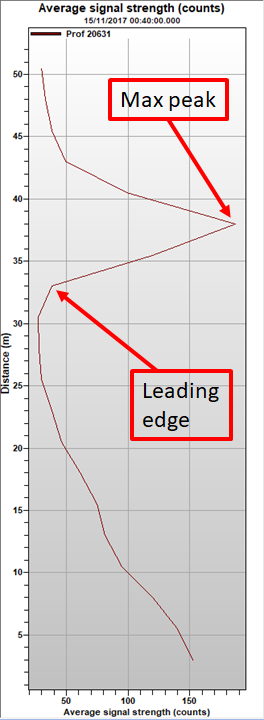


In the figure below we have plotted both the AST method and the LE method alongside the most common way to measure depth, pressure. This data was collected in a test of the instrument in the ICW on an extremely calm day with almost insignifigant waves. Notice the LE detecting a "resonant surface layer" at twice the depth measured by the AST and Pressure. Notice as well at 13:32, theres a region where both the altimeter data fields dip well below the pressure. These are the areads that highlight the need for quality control of the AST methods data output. These changes are small enough (~10cm) that they would be almost undetectable in real ocean environments with sea swell waves.

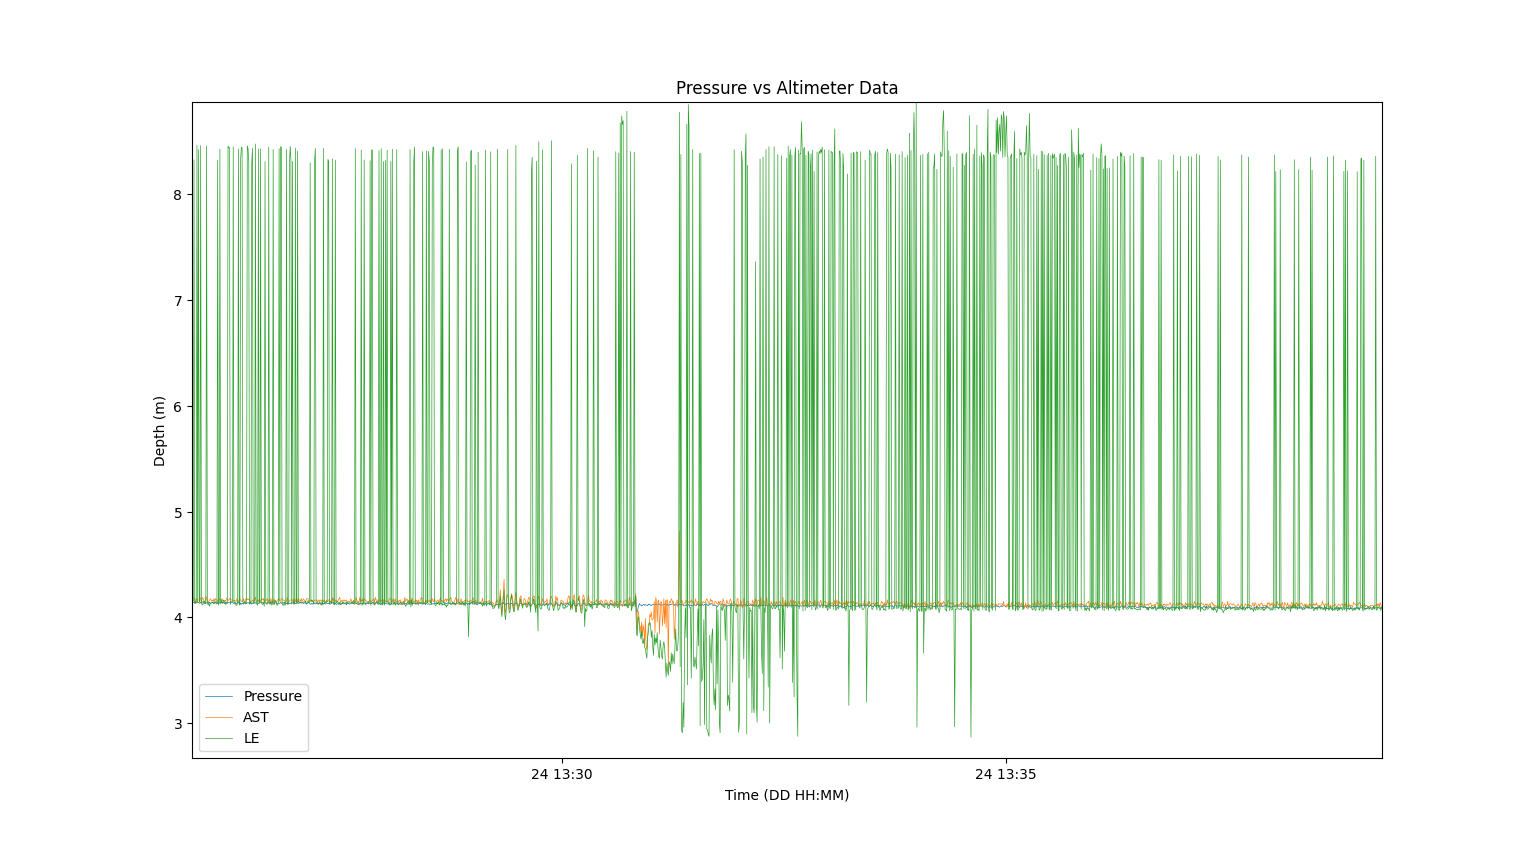

This figure also highlights the potential strengths of using the AST as a measure of depth over pressure, sensitivity to small wavelength waves at depth. Due to pressure attenuation, pressure sensors are 

In [32]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import sys
sys.path.append(r'C:\Users\lwlav\.vscode\repo\BOEM-Oak-Island\Post_Processing_Scripts')
from spectral_sediment import lowpass_filter, goring_nikora_despike
import pandas as pd
import os
import datetime 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy import signal

deployment_num = 4
sensor_id = ["S1_103080"]
#directory_initial_user_path = r"/Volumes/BOEM/"  # Katherine
# directory_initial_user_path = r"/Volumes/kanarde/BOEM/"  # Brooke
directory_initial_user_path = r"Z:/"  # Levi

In [33]:
# Import bulkstats and create dictionary for each sensor
for sensor in sensor_id:
    dirpath=os.path.join(directory_initial_user_path, f"deployment_{deployment_num}/BulkStats/",sensor)
    files = os.listdir(dirpath) # list of files for the sensor
    waves = {}
    for file in files:
        file_path = os.path.join(dirpath, file)  # file path
        df = pd.read_hdf(file_path)  # read the file into a Pandas dataframe
        file_name = file.split('.')[0]  # file name 
        print(file_name)
        waves[file_name] = df  # store dataframe
    globals()[f"waves_{sensor}"] = waves

ASTPressureSpectra
BottomhalfScatterersavg
BotVolumetricBackscatter1
DepthAveragedCurrentVelocity
DepthAveragedEastVelocity
DepthAveragedFlowDirection
DepthAveragedNorthVelocity
DepthAveragedUpVelocity
EastVelSpectra
Echo1avg
Frequencies
Frequencies_AST
FullEastVelocity
FullNorthVelocity
FullUpVelocity
GroupSpeed
MeanDirection1
MeanDirection2
MeanPeriod
MeanSpread1
MeanSpread2
NorthVelSpectra
Pressure
PressureEastVelCospectra
PressureNorthVelCospectra
PressureSpectra
SedTime
SignificantWaveHeight
TargetStrength
Time
TophalfScatterersavg
TopVolumetricBackscatter1
Vertavg
VolumetricBackscatter1
WaveCelerity
WaveNumbers


In [37]:
# Import single group to highlight AST processing methods
filepath = r"Z:\deployment_4\Raw\S1_103080_hdf\Group15\Burst_AltimeterDistanceAST.h5"
filepath2 = r"Z:\deployment_4\Raw\S1_103080_hdf\Group15\Burst_AltimeterQualityAST.h5"
filepath3 = r"Z:\deployment_4\Raw\S1_103080_hdf\Group15\Burst_Pressure.h5"

ast = pd.read_hdf(filepath)
astqual = pd.read_hdf(filepath2)
pressure = pd.read_hdf(filepath3)
pressure = pressure - .508 # adjust for sensor height to get depth from pressure reading

In [38]:
print(pd.read_hdf(r'z:\deployment_5\Raw\S1_101481_hdf\Group01\Burst_SamplingRate.h5'))

   0
0  4


In [39]:
print(pressure.max())
print(ast.max())

0    10.611
dtype: float32
0    11.374734
dtype: float32


In [40]:
###Break data into hourly sections for processing
sf = 4
Nsamp = sf * 3600 
nt = len(ast)
chunks = nt // Nsamp

for i in range(chunks):
    start = i * Nsamp
    end = (i + 1) * Nsamp
    ast_chunk = ast.iloc[start:end]
    astqual_chunk = astqual.iloc[start:end]
    pressure_chunk = pressure.iloc[start:end]
    #Quadratically detrend data and apply lowpass filter (f < .01Hz) according to Rutten et al 2024  https://doi.org/10.3390/data9050070 
    trend_ast = np.polynomial.polynomial.polyval(ast_chunk.index.values,np.polynomial.polynomial.polyfit(ast_chunk.index.values, ast_chunk.values, deg = 2))
    trend_pressure = np.polynomial.polynomial.polyval(pressure_chunk.index.values,np.polynomial.polynomial.polyfit(pressure_chunk.index.values, pressure_chunk.values, deg = 2))

    ast_chunk = ast_chunk - trend_ast.T
    pressure_chunk = pressure_chunk - trend_pressure.T

    pressure_pass = lowpass_filter(pressure_chunk, fs=4, cutoff=0.01, order=4)
    ast_pass = lowpass_filter(ast_chunk, fs=4, cutoff=0.01, order=4)

    #Get accurate depth reading from pressure, sensor height, attenuation, etc. 
    sensor_height = .508
    depthp = pressure_pass 




C:\Users\lwlav\AppData\Local\Temp\ipykernel_5852\2886355003.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fmax=float(freq_nonan.iloc[-1]) # grab maximum frequency for plotting


0.328125


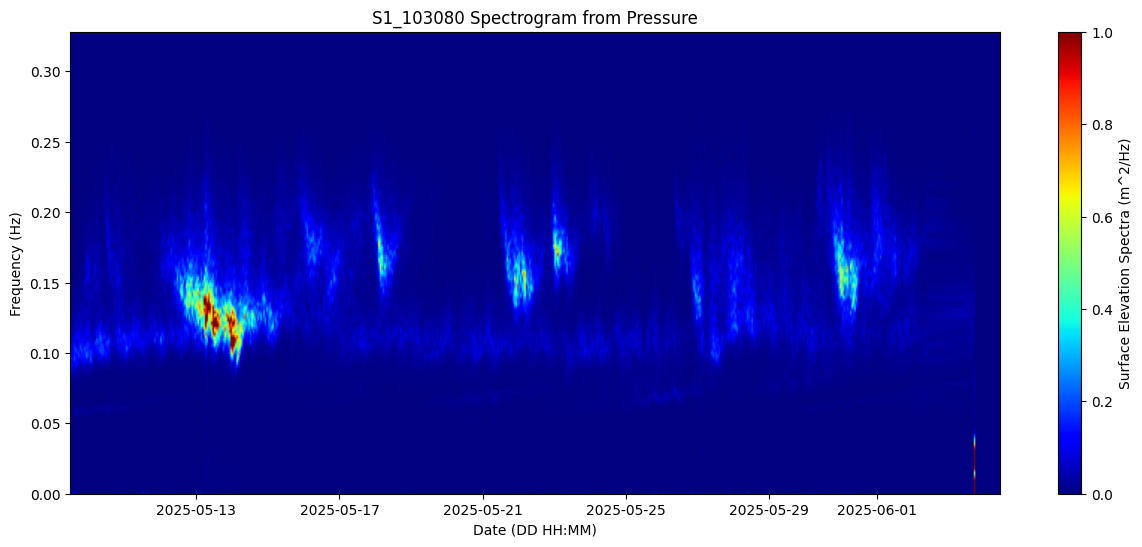

C:\Users\lwlav\AppData\Local\Temp\ipykernel_5852\2886355003.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fmax2=float(freq_nonan.iloc[-1]) # grab maximum frequency for plotting


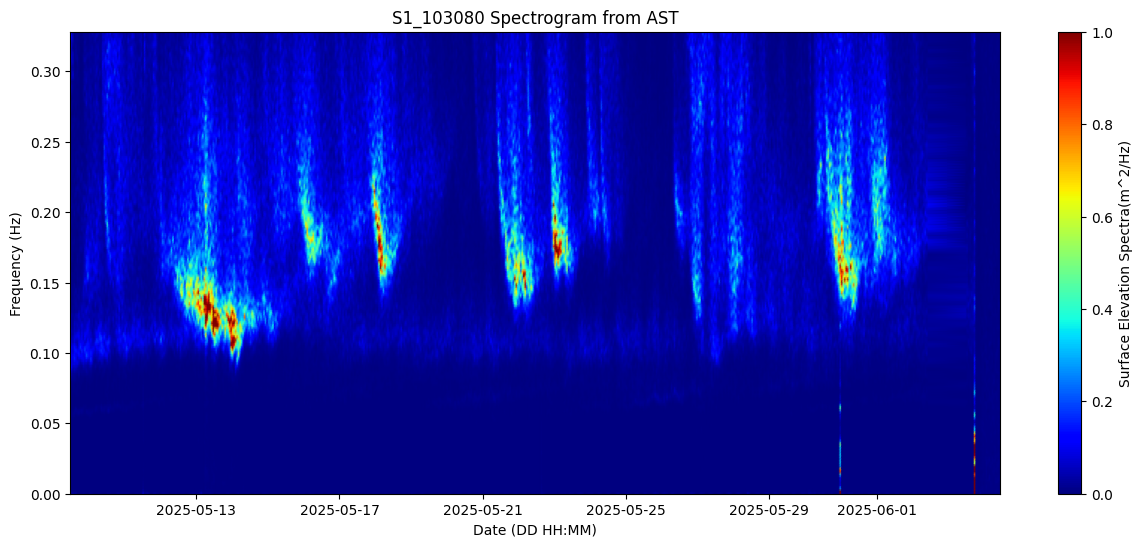

In [45]:
###Compare spectra between AST surface elevation and pressure attenuated surface elevation (from nulkstats calculated outisde of this script)
"""-------------------Pressure-------------------"""
df=waves_S1_103080['PressureSpectra']
df=df.iloc[:,:-1]

freq_nonan=waves_S1_103080['Frequencies'].fillna(0) # fill NaNs with zeros for plotting
fmax=float(freq_nonan.iloc[-1]) # grab maximum frequency for plotting
print(fmax)

# create a meshgrid of time and frequency
x,y=np.meshgrid(waves_S1_103080['Time'],freq_nonan)
z=df

# Plot energy spectra over time per cell
plt.figure(figsize=(15,6))
plt.pcolormesh(
    x,y,z.T, cmap='jet', shading='gouraud', vmin=0, vmax=1
)
plt.ylim(top=fmax)
plt.xlabel("Date (DD HH:MM)")
plt.ylabel("Frequency (Hz)")
plt.title('S1_103080 Spectrogram from Pressure')
im1=plt.colorbar()
im1.ax.set_ylabel("Surface Elevation Spectra (m^2/Hz)")
plt.show()


""""-------------------AST------------------------"""

df=waves_S1_103080['ASTPressureSpectra']
df=df.iloc[:,:-1]

freq_nonan=waves_S1_103080['Frequencies'].fillna(0) # fill NaNs with zeros for plotting
fmax2=float(freq_nonan.iloc[-1]) # grab maximum frequency for plotting

# create a meshgrid of time and frequency
x,y=np.meshgrid(waves_S1_103080['Time'],freq_nonan)
z=df

# Plot energy spectra over time per cell
plt.figure(figsize=(15,6))
plt.pcolormesh(
    x,y,z.T, cmap='jet', shading='gouraud', vmin=0, vmax=1
)
plt.ylim(top=fmax2)
plt.xlabel("Date (DD HH:MM)")
plt.ylabel("Frequency (Hz)")
plt.title('S1_103080 Spectrogram from AST')
im1=plt.colorbar()
im1.ax.set_ylabel("Surface Elevation Spectra(m^2/Hz)")
plt.show()
